# 設定
1. Set parameters in `set_params.py`
2. Put it in `data_dir`

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lorenz96_cython import rk4_cython
from lorenz96_cython import lorenz96_cython
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF
import visualize as vis
from util import load_params

In [29]:
data_dir = "data/r0"
import os

# Define the function to load the module
# def load_params(path_str):
#     import importlib.util

#     # Construct the path to the set_params.py file
#     params_path = os.path.join(path_str, 'set_params.py')

#     # Load the module
#     spec = importlib.util.spec_from_file_location("set_params", params_path)
#     set_params = importlib.util.module_from_spec(spec)
#     spec.loader.exec_module(set_params)

#     return set_params

# Use the function to load the parameters
set_params = load_params(data_dir)

# Access the parameters
J = set_params.J
F = set_params.F
dt = set_params.dt
N = set_params.N
obs_per = set_params.obs_per
# Nt = set_params.Nt
T_inf = set_params.T_inf
r = set_params.r
N_spinup = set_params.N_spinup
m_reduced_list = set_params.m_reduced_list
alpha_list = set_params.alpha_list
seeds = set_params.seeds

# print params
# TODO: make function to print params
print(f"Number of variables: {J}")
print(f"Model parameter F: {F}")
print(f"Time step size: {dt}")
print(f"Number of time steps for nature run: {N}")
print(f"Number of time steps per which observations are obtatined: {obs_per}")
# print(f"Number of time steps for OSSE: {Nt}")
print(f"Length of the spin-up period: {N_spinup}")
print(f"Start Time to evaluate the quality of OSSE: {T_inf}")
print(f"Std. of observation noise: {r}")
print(f"List of number of ensemble members: {m_reduced_list}")
print(f"List of inflation factors: {alpha_list}")
print(f"List of random seeds: {seeds}")

Number of variables: 40
Model parameter F: 8
Time step size: 0.01
Number of time steps for nature run: 79200
Number of time steps per which observations are obtatined: 5
Number of time steps for OSSE: 14400
Length of the spin-up period: 720
Start Time to evaluate the quality of OSSE: 7200
Std. of observation noise: 1.0
List of number of ensemble members: [12, 13, 14, 15, 16, 17, 18]
List of inflation factors: [1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3]
List of random seeds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Lorenz 96
$ J = 40 $, $ F = 8 $のとき，positive-neutral Lyapunov exponentは14個

In [30]:
print("(J, F):", (J, F))

(J, F): (40, 8)


### Generate test data

In [ ]:
# generate data
# dt: time step size
# dt = 0.
print(f"dt: {dt}")

# N: number of time step, 1 year : 360*20
assert N > 360*20
print(f"N: {N}")

# initial state near the stationary point
x0 = F*np.ones(J) # the stationary point
x0[19] *= 1.001 # perturb

# use my modules
scheme = rk4_cython
# p = (F, )
p = (np.ones(J)*F,)

result = np.zeros((N,len(x0)))
x = x0

# spin up 1 year
for n in range(1, 360*20):
    t = n*dt
    # x = scheme(lorenz96, t, x, p, dt) # without using cython
    x = scheme(lorenz96_cython, t, x, *p, dt)

# Nature run on the attractor
result[0] = x[:]
for n in range(1, N):
    t = n*dt
    # x = scheme(lorenz96, t, x, p, dt) # without using cython
    x = scheme(lorenz96_cython, t, x, *p, dt)
    result[n] = x[:]

# save the result
x_true = result[::obs_per] # save per 
print("x_true.shape", x_true.shape)
np.save(f"{data_dir}/x_true_l96", x_true)

dt: 0.01
N: 79200
(14400, 40)


## DA setting

In [32]:
# assimilation period
Dt = obs_per*dt

# Model function for EnKF
# def M(x, Dt):
#     for _ in range(int(Dt/dt)):
#         x = rk4(lorenz96, 0, x, p, dt)
#     return x

def M_cython(x, Dt):
    for _ in range(int(Dt/dt)):
        x = rk4_cython(lorenz96_cython, 0, x, *p, dt)
    return x

# 観測
H_diag = np.ones(J)
H = np.diag(H_diag)
print("diag of H:", H_diag)
print("rank(H):", np.linalg.matrix_rank(H))

# Model error covariance
Q = np.zeros((J, J))

# Observation error covariance
print("r:", r)
R = r**2*np.eye(J)


# generate observation
x_true = np.load(f'{data_dir}/x_true_l96.npy')

# initial ensemble size
m0 = J+1

# initial state for EnKF
# x_0 = x_true[np.random.randint(len(x_true)-1)]

# # random ensemble
# P_0 = 25*np.eye(J)
# X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)

# # deterministic ensemble
# X_0 = np.zeros((m, J))
# for i in range(m):
#     if i == J:
#        e = X_0[:J].sum(axis=0)
#        X_0[J] = e
#     else:
#         e = np.zeros(J)
#         e[i] = 1
#         X_0[i] = e
# X_0 *= 1

# inflation
# alpha = 1.2

diag of H: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H): 40
r: 1.0
Nt: 14400
x_true.shape (14400, 40)


## ETKF with ensemble reduction
To see that "good" initial ensemble and accurate observation provide stably accurate state estimation.
(Motived by Tokman-Hunt 2013)

Assume extremely accurate observation.
1. Assimilate until `N_spinup` time with large ensemble.
2. After ensemble mean reaches to the truth, reduce ensemble using SVD.

In [36]:
# RUN OSSE first with large ensemble, then reduce ensemble size
# loop for m
# 70min
from util import reduce_by_svd, reduce_by_sample

param_dict = {}
filename = data_dir + "/{}-{}{}{}"

# loop length
print(f"{len(m_reduced_list)*len(alpha_list)*len(seeds)} loops")
for i, m_reduced in enumerate(m_reduced_list):
    for j, alpha in enumerate(alpha_list):
        for k, seed in enumerate(seeds):
            param_dict[(i,j,k)] = (m_reduced, alpha, seed)
            try:
                Xa = np.load(filename.format("xa", i, j, k) + ".npy")
                print(filename.format("xa", i, j, k) + ".npy loaded" )
                print("Xa.shape", Xa.shape)
            except:
                print(i, j, k)
                
                np.random.seed(seed)
                # generate obs
                y = (H@x_true.T).T
                y += np.random.normal(loc=0, scale=r, size=y.shape) # R = r^2*I
                
                # generate initial ensemble
                x_0 = x_true[np.random.randint(len(x_true)-1)]
                P_0 = 25*np.eye(J)
                X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m0)  # (m0, dim_x) 
                
                # run spin-up
                print("spin-up")
                etkf = ETKF(M_cython, H, R, alpha=alpha, store_ensemble=True)
                etkf.initialize(X_0)
                for y_obs in tqdm(y[:N_spinup]):
                    etkf.forecast(Dt)
                    etkf.update(y_obs)

                # save spin-up data
                np.save(filename.format("xf_spinup", i, j, k), etkf.Xf)
                np.save(filename.format("xa_spinup", i, j, k), etkf.Xa)

                # reduce ensemble
                X_reduced = reduce_by_svd(etkf.X, m_reduced) # by SVD
                # X_reduced = reduce_by_sample(etkf.X, m_reduced) # by random sampling
                etkf.initialize(X_reduced)
                # etkf.alpha = 1.0
                print("assimilation")
                for y_obs in tqdm(y[N_spinup:]):
                    etkf.forecast(Dt)
                    etkf.update(y_obs)

                # save data
                np.save(filename.format("xf", i, j, k), etkf.Xf)
                np.save(filename.format("xa", i, j, k), etkf.Xa)

490 loops
0 0 0
spin-up


  0%|          | 0/720 [00:00<?, ?it/s]

100%|██████████| 720/720 [00:02<00:00, 315.40it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1098.79it/s]


0 0 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.87it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1123.19it/s]


0 0 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.31it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1125.60it/s]


0 0 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.12it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1130.10it/s]


0 0 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.11it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1128.54it/s]


0 0 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.06it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1125.97it/s]


0 0 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.73it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1128.55it/s]


0 0 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.88it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1131.06it/s]


0 0 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.33it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1128.87it/s]


0 0 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.58it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1128.89it/s]


0 1 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.65it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1109.79it/s]


0 1 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.10it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1122.36it/s]


0 1 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.91it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1129.84it/s]


0 1 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.77it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1117.58it/s]


0 1 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.83it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1094.72it/s]


0 1 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.79it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1115.16it/s]


0 1 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.48it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1107.80it/s]


0 1 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 339.53it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1137.77it/s]


0 1 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.77it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1137.09it/s]


0 1 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 341.28it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1107.27it/s]


0 2 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.42it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1115.74it/s]


0 2 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.42it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1115.24it/s]


0 2 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.08it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1103.94it/s]


0 2 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.31it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1110.37it/s]


0 2 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.48it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1080.59it/s]


0 2 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.91it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1098.75it/s]


0 2 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.83it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1088.89it/s]


0 2 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.58it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1120.95it/s]


0 2 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.54it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1111.74it/s]


0 2 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.71it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1115.33it/s]


0 3 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.08it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1131.13it/s]


0 3 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.34it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1136.68it/s]


0 3 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.92it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1104.07it/s]


0 3 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.69it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1110.21it/s]


0 3 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.23it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1110.94it/s]


0 3 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.25it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1106.80it/s]


0 3 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.20it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1113.66it/s]


0 3 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.40it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1137.70it/s]


0 3 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.12it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1123.34it/s]


0 3 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.56it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1124.91it/s]


0 4 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.92it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1106.11it/s]


0 4 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.39it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1120.42it/s]


0 4 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.93it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1102.67it/s]


0 4 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.19it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1100.53it/s]


0 4 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.69it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1126.58it/s]


0 4 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.76it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1111.50it/s]


0 4 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.71it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1119.52it/s]


0 4 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.94it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1106.22it/s]


0 4 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.91it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1102.77it/s]


0 4 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.49it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1098.28it/s]


0 5 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.16it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1093.38it/s]


0 5 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.12it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1113.96it/s]


0 5 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.80it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1128.58it/s]


0 5 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.30it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1112.52it/s]


0 5 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.55it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1116.45it/s]


0 5 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.18it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1127.91it/s]


0 5 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.55it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1125.43it/s]


0 5 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.99it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1116.38it/s]


0 5 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.08it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1120.05it/s]


0 5 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.80it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1116.92it/s]


0 6 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.76it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1127.58it/s]


0 6 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.39it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1130.10it/s]


0 6 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.71it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1089.77it/s]


0 6 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.08it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1106.58it/s]


0 6 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.21it/s]


assimilation


100%|██████████| 13680/13680 [00:11<00:00, 1141.77it/s]


0 6 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.72it/s]


assimilation


100%|██████████| 13680/13680 [00:11<00:00, 1148.56it/s]


0 6 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.34it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1122.48it/s]


0 6 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.42it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1121.57it/s]


0 6 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.62it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1104.22it/s]


0 6 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.61it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1106.07it/s]


1 0 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.36it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1030.68it/s]


1 0 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 340.12it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1052.89it/s]


1 0 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.72it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1051.07it/s]


1 0 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.05it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1029.06it/s]


1 0 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.69it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1031.28it/s]


1 0 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.29it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1041.73it/s]


1 0 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.85it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1059.91it/s]


1 0 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 340.64it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1051.40it/s]


1 0 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.05it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1031.67it/s]


1 0 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.16it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1023.16it/s]


1 1 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.81it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1022.14it/s]


1 1 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 340.72it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1031.93it/s]


1 1 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.38it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1027.52it/s]


1 1 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.84it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1046.31it/s]


1 1 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 340.85it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1050.98it/s]


1 1 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.86it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1033.18it/s]


1 1 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.95it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1046.83it/s]


1 1 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 339.79it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1033.71it/s]


1 1 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.89it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1035.11it/s]


1 1 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.63it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1006.39it/s]


1 2 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.50it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1013.81it/s]


1 2 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.17it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1022.18it/s]


1 2 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.54it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1040.22it/s]


1 2 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.51it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1040.64it/s]


1 2 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.16it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1040.27it/s]


1 2 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.60it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1022.17it/s]


1 2 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.74it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1026.88it/s]


1 2 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.93it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1037.37it/s]


1 2 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.79it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1024.97it/s]


1 2 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.58it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1031.97it/s]


1 3 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.58it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1050.79it/s]


1 3 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.08it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1044.96it/s]


1 3 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.94it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1019.74it/s]


1 3 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.04it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1034.08it/s]


1 3 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.94it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1013.11it/s]


1 3 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.07it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1039.67it/s]


1 3 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.55it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1019.66it/s]


1 3 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.71it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1024.55it/s]


1 3 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.94it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1048.56it/s]


1 3 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.38it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1024.16it/s]


1 4 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.39it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1032.12it/s]


1 4 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.40it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1031.67it/s]


1 4 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.79it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1013.45it/s]


1 4 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 302.39it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1026.16it/s]


1 4 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.24it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1049.31it/s]


1 4 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.22it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1046.37it/s]


1 4 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.40it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1042.25it/s]


1 4 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.76it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1045.82it/s]


1 4 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.62it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1053.27it/s]


1 4 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.31it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1046.91it/s]


1 5 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.53it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1029.89it/s]


1 5 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.67it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1049.94it/s]


1 5 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.80it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1050.38it/s]


1 5 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.06it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1030.12it/s]


1 5 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.85it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1050.80it/s]


1 5 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.04it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1054.46it/s]


1 5 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.60it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1054.05it/s]


1 5 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.74it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1050.35it/s]


1 5 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.24it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1050.67it/s]


1 5 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.56it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1048.10it/s]


1 6 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.78it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1031.88it/s]


1 6 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.74it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1037.81it/s]


1 6 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.40it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1035.56it/s]


1 6 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.09it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1054.26it/s]


1 6 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.02it/s]


assimilation


100%|██████████| 13680/13680 [00:12<00:00, 1054.44it/s]


1 6 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.45it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1024.76it/s]


1 6 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.17it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1010.10it/s]


1 6 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.45it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1016.73it/s]


1 6 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 311.96it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1036.69it/s]


1 6 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.94it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 1016.69it/s]


2 0 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.16it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 951.48it/s]


2 0 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.13it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 961.96it/s]


2 0 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.73it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 974.20it/s]


2 0 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 339.96it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 985.92it/s]


2 0 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.25it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 967.27it/s]


2 0 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.35it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 988.06it/s]


2 0 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 339.64it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 982.56it/s]


2 0 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.82it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 987.69it/s]


2 0 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 339.09it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 988.21it/s]


2 0 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.88it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 981.38it/s]


2 1 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.97it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 986.32it/s]


2 1 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.01it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 956.23it/s]


2 1 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 316.66it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 961.25it/s]


2 1 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.21it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 955.55it/s]


2 1 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.67it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 942.81it/s]


2 1 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.07it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 940.30it/s]


2 1 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 315.25it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 958.93it/s]


2 1 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.76it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 955.96it/s]


2 1 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.94it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 945.53it/s]


2 1 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.99it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 951.36it/s]


2 2 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.18it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 958.18it/s]


2 2 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.41it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 980.24it/s]


2 2 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 316.31it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 948.35it/s]


2 2 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.30it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 964.28it/s]


2 2 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.80it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 987.13it/s]


2 2 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.23it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 979.44it/s] 


2 2 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.58it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 987.87it/s]


2 2 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.45it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 978.14it/s]


2 2 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.34it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 982.11it/s]


2 2 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.42it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 971.73it/s]


2 3 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.97it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 979.87it/s]


2 3 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.37it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 971.46it/s]


2 3 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.13it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 949.90it/s]


2 3 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.62it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 953.05it/s]


2 3 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.78it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 966.58it/s]


2 3 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.98it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 969.08it/s]


2 3 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.90it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 958.38it/s]


2 3 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.85it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 956.44it/s]


2 3 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.20it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 976.71it/s]


2 3 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.19it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 978.30it/s]


2 4 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.45it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 986.44it/s] 


2 4 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.19it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 983.73it/s]


2 4 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.50it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 983.55it/s] 


2 4 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.49it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 978.17it/s]


2 4 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.95it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 958.38it/s]


2 4 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.25it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 961.21it/s]


2 4 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.40it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 966.01it/s]


2 4 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.81it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 954.17it/s]


2 4 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.35it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 963.10it/s]


2 4 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.48it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 957.12it/s]


2 5 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.55it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 975.10it/s] 


2 5 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.22it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 961.02it/s]


2 5 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.71it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 953.06it/s]


2 5 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.91it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 961.32it/s]


2 5 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.73it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 962.92it/s]


2 5 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.12it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 963.25it/s]


2 5 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.33it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 946.87it/s]


2 5 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.57it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 956.01it/s]


2 5 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.41it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 966.78it/s]


2 5 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.11it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 974.40it/s]


2 6 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.17it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 961.09it/s]


2 6 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.26it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 942.87it/s]


2 6 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.51it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 956.84it/s]


2 6 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.39it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 953.62it/s]


2 6 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.07it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 968.23it/s]


2 6 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.93it/s]


assimilation


100%|██████████| 13680/13680 [00:13<00:00, 979.26it/s]


2 6 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 314.65it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 960.74it/s]


2 6 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.02it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 945.75it/s]


2 6 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.97it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 962.22it/s]


2 6 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.19it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 950.92it/s]


3 0 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.81it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 892.16it/s]


3 0 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.52it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 891.18it/s]


3 0 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.72it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 892.77it/s]


3 0 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.26it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 898.46it/s]


3 0 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.46it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 900.29it/s]


3 0 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.83it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 895.50it/s]


3 0 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.38it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 884.27it/s]


3 0 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.42it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 895.05it/s]


3 0 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.14it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 909.19it/s]


3 0 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.62it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 906.29it/s]


3 1 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.95it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 899.60it/s]


3 1 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 315.34it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 901.72it/s]


3 1 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.05it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 906.72it/s]


3 1 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.00it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 904.25it/s]


3 1 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.41it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 906.22it/s]


3 1 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.83it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 909.98it/s]


3 1 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 334.44it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 907.81it/s]


3 1 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.81it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 912.85it/s]


3 1 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.64it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 911.55it/s]


3 1 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.82it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 918.18it/s]


3 2 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.91it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 910.37it/s]


3 2 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.45it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 894.46it/s]


3 2 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.84it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 900.60it/s]


3 2 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.36it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 895.79it/s]


3 2 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 335.63it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 905.45it/s]


3 2 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.54it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 915.64it/s]


3 2 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.39it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 895.09it/s]


3 2 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.26it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 918.98it/s]


3 2 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.51it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 922.72it/s]


3 2 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.69it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 922.99it/s]


3 3 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.97it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 921.00it/s]


3 3 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 336.07it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 923.11it/s]


3 3 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.72it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 922.61it/s]


3 3 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.34it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 923.24it/s]


3 3 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 337.45it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 902.49it/s]


3 3 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.92it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 900.10it/s]


3 3 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 330.51it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 920.18it/s]


3 3 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.11it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 888.33it/s]


3 3 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.29it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 899.59it/s]


3 3 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.27it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 903.35it/s]


3 4 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.54it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 890.88it/s]


3 4 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.08it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 896.89it/s]


3 4 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 331.50it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 891.56it/s]


3 4 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.53it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 910.38it/s]


3 4 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 333.47it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 916.07it/s]


3 4 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 332.43it/s]


assimilation


100%|██████████| 13680/13680 [00:14<00:00, 916.21it/s]


3 4 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.06it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 873.34it/s]


3 4 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 311.97it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 883.75it/s]


3 4 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 312.45it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 858.45it/s]


3 4 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 312.73it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 859.76it/s]


3 5 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 316.01it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 849.16it/s]


3 5 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 305.97it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 856.06it/s]


3 5 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.06it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 873.46it/s]


3 5 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 311.31it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 870.41it/s]


3 5 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.79it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 882.03it/s]


3 5 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.14it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 863.66it/s]


3 5 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 315.47it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 869.12it/s]


3 5 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 312.67it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 876.53it/s]


3 5 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.38it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 881.83it/s]


3 5 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.20it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 882.24it/s]


3 6 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.95it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 882.33it/s]


3 6 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.47it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 883.71it/s]


3 6 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.14it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 883.57it/s]


3 6 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.55it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 883.80it/s]


3 6 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.58it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 880.42it/s]


3 6 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.95it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 882.77it/s]


3 6 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.13it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 884.72it/s]


3 6 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.06it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 883.58it/s]


3 6 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.92it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 881.42it/s]


3 6 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 316.10it/s]


assimilation


100%|██████████| 13680/13680 [00:15<00:00, 882.97it/s]


4 0 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.09it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 832.54it/s]


4 0 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.85it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 834.60it/s]


4 0 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.63it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 833.99it/s]


4 0 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.38it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 833.33it/s]


4 0 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.44it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 833.60it/s]


4 0 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.75it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 833.13it/s]


4 0 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.03it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 825.88it/s]


4 0 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.51it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 833.53it/s]


4 0 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.05it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 830.65it/s]


4 0 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.64it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 832.50it/s]


4 1 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.93it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 831.10it/s]


4 1 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.15it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 827.81it/s]


4 1 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.74it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 832.46it/s]


4 1 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.17it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 828.47it/s]


4 1 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.86it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 829.56it/s]


4 1 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.62it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 832.49it/s]


4 1 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.85it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 831.20it/s]


4 1 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.61it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 833.58it/s]


4 1 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.57it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 831.45it/s]


4 1 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.84it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 831.97it/s]


4 2 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.79it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 816.29it/s]


4 2 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 316.20it/s]


assimilation


100%|██████████| 13680/13680 [00:44<00:00, 307.23it/s]


4 2 2
spin-up


100%|██████████| 720/720 [00:03<00:00, 191.81it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 841.19it/s]


4 2 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.65it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 840.35it/s]


4 2 4
spin-up


100%|██████████| 720/720 [06:55<00:00,  1.73it/s] 


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 815.74it/s]


4 2 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.52it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 839.31it/s]


4 2 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.67it/s]


assimilation


100%|██████████| 13680/13680 [02:01<00:00, 112.24it/s]


4 2 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.45it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 843.59it/s]


4 2 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.53it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 839.33it/s]


4 2 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.15it/s]


assimilation


100%|██████████| 13680/13680 [15:58<00:00, 14.28it/s] 


4 3 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.89it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 837.09it/s]


4 3 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.01it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 843.69it/s]


4 3 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.04it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 842.54it/s]


4 3 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.66it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 844.66it/s]


4 3 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.79it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 845.01it/s]


4 3 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.35it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 842.78it/s]


4 3 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.74it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 844.06it/s]


4 3 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 315.16it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 843.41it/s]


4 3 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.85it/s]


assimilation


100%|██████████| 13680/13680 [07:10<00:00, 31.79it/s] 


4 3 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 267.09it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 786.06it/s]


4 4 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.20it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 810.43it/s]


4 4 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.44it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 826.53it/s]


4 4 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.19it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 826.41it/s]


4 4 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.35it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 813.24it/s]


4 4 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.26it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 832.20it/s]


4 4 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.10it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 829.44it/s]


4 4 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 315.30it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 812.37it/s]


4 4 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 306.67it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 819.70it/s]


4 4 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 309.39it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 822.38it/s]


4 4 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.81it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 831.68it/s]


4 5 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.65it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 833.31it/s]


4 5 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.81it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 831.86it/s]


4 5 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.50it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 830.91it/s]


4 5 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.81it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 832.65it/s]


4 5 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.73it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 820.30it/s]


4 5 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 308.74it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 815.82it/s]


4 5 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 309.86it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 822.25it/s]


4 5 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 313.90it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 831.52it/s]


4 5 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.40it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 827.12it/s]


4 5 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.56it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 820.88it/s]


4 6 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 315.77it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 822.08it/s]


4 6 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.19it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 812.18it/s]


4 6 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 316.18it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 830.54it/s]


4 6 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.68it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 826.44it/s]


4 6 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.57it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 826.59it/s]


4 6 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.63it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 827.61it/s]


4 6 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.72it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 825.54it/s]


4 6 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.64it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 819.73it/s]


4 6 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 312.73it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 823.63it/s]


4 6 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.55it/s]


assimilation


100%|██████████| 13680/13680 [00:16<00:00, 832.55it/s]


5 0 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.82it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 781.42it/s]


5 0 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.16it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.44it/s]


5 0 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.88it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.55it/s]


5 0 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.16it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 781.53it/s]


5 0 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.37it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.89it/s]


5 0 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.17it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.98it/s]


5 0 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.82it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 784.82it/s]


5 0 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.22it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.38it/s]


5 0 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.63it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.40it/s]


5 0 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.44it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.80it/s]


5 1 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.98it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.17it/s]


5 1 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.47it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 784.38it/s]


5 1 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.34it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.36it/s]


5 1 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.49it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 784.34it/s]


5 1 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.54it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 780.95it/s]


5 1 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.17it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.74it/s]


5 1 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.84it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.37it/s]


5 1 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.06it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.70it/s]


5 1 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.48it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.76it/s]


5 1 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.07it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 779.97it/s]


5 2 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.36it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.07it/s]


5 2 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.83it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.96it/s]


5 2 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.94it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 780.97it/s]


5 2 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.74it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.50it/s]


5 2 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.52it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.40it/s]


5 2 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.67it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 783.16it/s]


5 2 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.90it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.48it/s]


5 2 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 326.30it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.53it/s]


5 2 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.98it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.15it/s]


5 2 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.99it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 767.35it/s]


5 3 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.25it/s]


assimilation


100%|██████████| 13680/13680 [00:45<00:00, 300.83it/s]


5 3 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.02it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 782.01it/s]


5 3 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.41it/s]


assimilation


100%|██████████| 13680/13680 [15:34<00:00, 14.64it/s]  


5 3 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.91it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 766.36it/s]


5 3 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.08it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 793.17it/s]


5 3 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.51it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 792.58it/s]


5 3 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.73it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 793.70it/s]


5 3 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.12it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 793.23it/s]


5 3 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.05it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 792.63it/s]


5 3 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 329.35it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 790.14it/s]


5 4 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 327.16it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 795.00it/s]


5 4 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.65it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 792.79it/s]


5 4 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 328.08it/s]


assimilation


100%|██████████| 13680/13680 [07:33<00:00, 30.18it/s]  


5 4 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 273.28it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 736.90it/s]


5 4 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 292.89it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 743.16it/s]


5 4 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 293.75it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 747.23it/s]


5 4 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 296.10it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 774.88it/s]


5 4 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 295.38it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 774.55it/s]


5 4 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.14it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 758.59it/s]


5 4 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 324.56it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 745.16it/s]


5 5 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 278.80it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 775.09it/s]


5 5 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.16it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 777.16it/s]


5 5 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 307.59it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 764.73it/s]


5 5 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.70it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 774.30it/s]


5 5 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.19it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 759.67it/s]


5 5 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 302.44it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 762.12it/s]


5 5 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 313.70it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 762.64it/s]


5 5 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.43it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 763.26it/s]


5 5 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.97it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 769.48it/s]


5 5 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 322.03it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 776.16it/s]


5 6 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.77it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 768.44it/s]


5 6 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.11it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 772.37it/s]


5 6 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 317.95it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 765.99it/s]


5 6 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 319.00it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 770.16it/s]


5 6 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.29it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 776.81it/s]


5 6 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 320.69it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 776.26it/s]


5 6 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 323.13it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 766.84it/s]


5 6 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 308.51it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 752.42it/s]


5 6 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 311.07it/s]


assimilation


100%|██████████| 13680/13680 [00:17<00:00, 762.26it/s]


5 6 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 315.64it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 759.47it/s]


6 0 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 325.39it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 728.03it/s]


6 0 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 318.36it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 720.21it/s]


6 0 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 315.18it/s]


assimilation


100%|██████████| 13680/13680 [00:18<00:00, 726.92it/s]


6 0 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 314.30it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 716.29it/s]


6 0 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 321.18it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 717.64it/s]


6 0 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 316.79it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 707.80it/s]


6 0 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 304.13it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 711.60it/s]


6 0 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 314.44it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 708.94it/s]


6 0 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 313.18it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 706.20it/s]


6 0 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 289.60it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 688.74it/s]


6 1 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 303.61it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 687.92it/s]


6 1 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 301.98it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 684.30it/s]


6 1 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 297.57it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 689.10it/s]


6 1 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 305.28it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 669.44it/s]


6 1 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 286.86it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 660.03it/s]


6 1 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 298.41it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 691.01it/s]


6 1 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 298.16it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 689.40it/s]


6 1 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 298.50it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.63it/s]


6 1 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 303.33it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 688.81it/s]


6 1 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 295.16it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 691.76it/s]


6 2 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 302.93it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 691.20it/s]


6 2 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 299.78it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 687.73it/s]


6 2 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 304.37it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.41it/s]


6 2 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 296.20it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 688.58it/s]


6 2 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 302.38it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 689.41it/s]


6 2 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 304.36it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 689.14it/s]


6 2 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 304.04it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 691.63it/s]


6 2 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 301.16it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 692.63it/s]


6 2 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 297.85it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 692.46it/s]


6 2 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 302.51it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.70it/s]


6 3 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 301.84it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.76it/s]


6 3 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 293.00it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 694.13it/s]


6 3 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 296.95it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.63it/s]


6 3 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 302.14it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.12it/s]


6 3 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 298.46it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.90it/s]


6 3 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 299.17it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 692.74it/s]


6 3 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 300.19it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 692.33it/s]


6 3 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 293.19it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 689.98it/s]


6 3 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 298.71it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 693.09it/s]


6 3 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 303.04it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.16it/s]


6 4 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 299.22it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 688.30it/s]


6 4 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 301.81it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 692.90it/s]


6 4 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 285.61it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 691.17it/s]


6 4 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 253.90it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 691.73it/s]


6 4 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 280.95it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 673.37it/s]


6 4 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 278.65it/s]


assimilation


100%|██████████| 13680/13680 [02:12<00:00, 103.10it/s]


6 4 6
spin-up


100%|██████████| 720/720 [00:04<00:00, 154.41it/s]


assimilation


100%|██████████| 13680/13680 [00:21<00:00, 638.67it/s]


6 4 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 291.36it/s]


assimilation


100%|██████████| 13680/13680 [00:21<00:00, 636.00it/s]


6 4 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 276.15it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 656.01it/s]


6 4 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 298.19it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 690.62it/s]


6 5 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 295.80it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 686.97it/s]


6 5 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 304.83it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 677.00it/s]


6 5 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 301.44it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 692.84it/s]


6 5 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 302.93it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 692.39it/s]


6 5 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 298.99it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 692.79it/s]


6 5 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 304.45it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 695.06it/s]


6 5 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 300.29it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 694.11it/s]


6 5 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 297.61it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 693.49it/s]


6 5 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 298.61it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 693.22it/s]


6 5 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 295.02it/s]


assimilation


100%|██████████| 13680/13680 [00:19<00:00, 685.79it/s]


6 6 0
spin-up


100%|██████████| 720/720 [00:02<00:00, 299.14it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 666.64it/s]


6 6 1
spin-up


100%|██████████| 720/720 [00:02<00:00, 279.81it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 679.21it/s]


6 6 2
spin-up


100%|██████████| 720/720 [00:02<00:00, 297.17it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 683.05it/s]


6 6 3
spin-up


100%|██████████| 720/720 [00:02<00:00, 291.10it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 682.40it/s]


6 6 4
spin-up


100%|██████████| 720/720 [00:02<00:00, 292.76it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 676.96it/s]


6 6 5
spin-up


100%|██████████| 720/720 [00:02<00:00, 299.39it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 666.82it/s]


6 6 6
spin-up


100%|██████████| 720/720 [00:02<00:00, 292.10it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 659.51it/s]


6 6 7
spin-up


100%|██████████| 720/720 [00:02<00:00, 288.01it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 673.42it/s]


6 6 8
spin-up


100%|██████████| 720/720 [00:02<00:00, 300.27it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 681.44it/s]


6 6 9
spin-up


100%|██████████| 720/720 [00:02<00:00, 272.35it/s]


assimilation


100%|██████████| 13680/13680 [00:20<00:00, 656.89it/s]


In [37]:
# def compute_limsupE(x):
#     """
#     Return limsup_t of Expectation(x(\omega, t)) over \omega.
#     Approximate by taking mean over \omega after T_inf.
#     x is assumed to be trancated after T_inf.
#     Args:
#         x: np.array (N_seed, T, *shape_data)
#     """
#     return np.max(np.mean(x, axis=0), axis=0)


In [38]:
# load
import pandas as pd
from util import compute_edims, compute_traceP

# parameter limsup
# T_inf = 500
print("T_inf", T_inf)

Xa_dict = {}
sup_se = np.zeros((len(m_reduced_list), len(alpha_list)))
rmse = np.zeros((len(m_reduced_list), len(alpha_list)))
traceP = np.zeros((len(m_reduced_list), len(alpha_list)))
ensdim = np.zeros((len(m_reduced_list), len(alpha_list)))
for i, m_reduced in enumerate(m_reduced_list):
    for j, alpha in enumerate(alpha_list):
        se_tmp = []
        rmse_tmp = []
        traceP_tmp = []
        ensdim_tmp = []
        print(i, j)
        for k, seed in enumerate(seeds):
            Xa_spinup = np.load(filename.format("xa_spinup", i, j, k) + ".npy")
            Xa = np.load(filename.format("xa", i, j, k) + ".npy")
            e = x_true[N_spinup:]-Xa.mean(axis=1)

            se_tmp.append(np.sum(e[T_inf:]**2, axis=-1)) # (T,)
            rmse_tmp.append(np.mean(np.linalg.norm(e[T_inf:], axis=-1)/np.sqrt(J)))
            traceP_tmp.append(np.mean(np.sqrt(compute_traceP(Xa[T_inf:])/J)))
            ensdim_tmp.append(np.mean(compute_edims(Xa[T_inf:])))
            
            Xa = [*Xa_spinup, *Xa]
            Xa_dict[(i, j, k)] = Xa
        
        sup_se[i, j] = np.max(np.mean(np.array(se_tmp), axis=0), axis=0)  # sup_t(E[SE])
        rmse[i, j] = np.mean(rmse_tmp)  # E[mean_t(RMSE)]
        traceP[i, j] = np.mean(traceP_tmp)  # E[mean_t(tr(Pa))]
        ensdim[i, j] = np.mean(ensdim_tmp)  # E[mean_t(D_ens)]

df_sup_se = pd.DataFrame(sup_se, index=m_reduced_list, columns=alpha_list)
df_rmse = pd.DataFrame(rmse, index=m_reduced_list, columns=alpha_list)
df_traceP = pd.DataFrame(traceP, index=m_reduced_list, columns=alpha_list)
df_ensdim = pd.DataFrame(ensdim, index=m_reduced_list, columns=alpha_list)

df_sup_se.to_csv(data_dir + "/" + "sup_se" + ".csv")
df_rmse.to_csv(data_dir + "/" + "rmse" + ".csv")

T_inf 7200
0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6


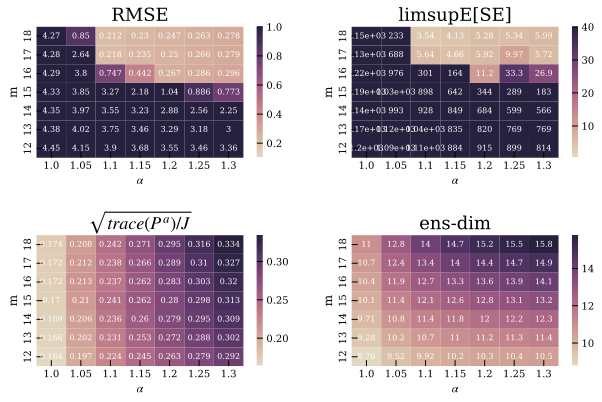

In [39]:
plt.rcParams['text.usetex'] = False # 場当たり的な対応
import seaborn as sns
cmap = "flare" # flare_r
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
fig, ax = plt.subplots(2, 2, figsize=(9, 6))

ax00 = ax[0, 1]
sns.heatmap(df_sup_se, ax=ax00, vmax=J*r**2, vmin=J*r**2/100, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax00.set_title("limsupE[SE]")
ax00.set_ylabel("m")
ax00.set_xlabel(r"$ \alpha $")
ax00.invert_yaxis()

ax01 = ax[0, 0]
sns.heatmap(df_rmse, ax=ax01, vmax=r, vmin=r/10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax01.set_title("RMSE")
ax01.set_ylabel("m")
ax01.set_xlabel(r"$ \alpha $")
ax01.invert_yaxis()

ax10 = ax[1, 0]
sns.heatmap(df_traceP, ax=ax10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax10.set_title(r"$\sqrt{trace(P^a)/J}$")
ax10.set_ylabel("m")
ax10.set_xlabel(r"$ \alpha $")
ax10.invert_yaxis()

ax11 = ax[1, 1]
sns.heatmap(df_ensdim, ax=ax11, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax11.set_title("ens-dim")
ax11.set_ylabel("m")
ax11.set_xlabel(r"$ \alpha $")
ax11.invert_yaxis()

fig.tight_layout()
fig.savefig(f"{data_dir}/index.pdf")

plt.show()


# if df_rmse.shape[0] > 1 and df_rmse.shape[1] > 1:
#     fig2, ax2 = plt.subplots(1, 2, figsize=(8, 3))
#     ax21 = ax2[0]
#     cf = ax21.contourf(df_rmse.columns, df_rmse.index, df_rmse, levels=[*np.linspace(r/10, r, 50)])
#     plt.colorbar(cf)
#     cs = ax21.contour(df_rmse.columns, df_rmse.index, df_ensdim, cmap="flare_r", levels=np.arange(10, 15, 0.5))
#     ax21.clabel(cs, cs.levels[1::2])
#     ax21.set_xlabel("$ \\alpha $")
#     ax21.set_ylabel("$ m $")
#     ax21.set_title("RMSE with ensemble-dim.")

#     ax22 = ax2[1]
#     cf = ax22.contourf(df_rmse.columns, df_rmse.index, df_rmse, levels=[*np.linspace(r/10, r, 50)])
#     plt.colorbar(cf)
#     cs = ax22.contour(df_rmse.columns, df_rmse.index, df_traceP, cmap="flare_r", levels=np.linspace(r/10, r*3/10, 10))
#     ax22.clabel(cs, cs.levels[1::2])
#     ax22.set_xlabel("$ \\alpha $")
#     ax22.set_ylabel("$ m $")
#     ax22.set_title("RMSE with trace(P).")
#     fig2.tight_layout()


# if df_sup_se.shape[0] > 1 and df_sup_se.shape[1] > 1:
#     fig3, ax3 = plt.subplots(1, 2, figsize=(8, 3))
#     ax31 = ax3[0]
#     # sns.heatmap(df_sup_se, ax=ax31, vmax=J*r**2, vmin=J*r**2/10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
#     cf = ax31.contourf(df_sup_se.columns, df_sup_se.index, df_sup_se, levels=[*np.linspace(J*r**2/100, J*r**2, 50)])
#     plt.colorbar(cf)
#     cs = ax31.contour(df_sup_se.columns, df_sup_se.index, df_ensdim, cmap="flare_r", levels=np.arange(10, 15, 0.5))
#     ax31.clabel(cs, cs.levels[1::2])
#     ax31.set_xlabel("$ \\alpha $")
#     ax31.set_ylabel("$ m $")
#     ax31.set_title("limsupE[SE] with ensemble-dim.")

#     ax32 = ax3[1]
#     cf = ax32.contourf(df_sup_se.columns, df_sup_se.index, df_sup_se, levels=[*np.linspace(J*r**2/100, J*r**2, 50)])
#     plt.colorbar(cf)
#     cs = ax32.contour(df_sup_se.columns, df_sup_se.index, df_traceP, cmap="flare_r", levels=np.linspace(r/10, r*3/10, 10))
#     ax32.clabel(cs, cs.levels[1::2])
#     ax32.set_xlabel("$ \\alpha $")
#     ax32.set_ylabel("$ m $")
#     ax32.set_title("limsupE[SE] with trace(P).")
#     fig3.tight_layout()

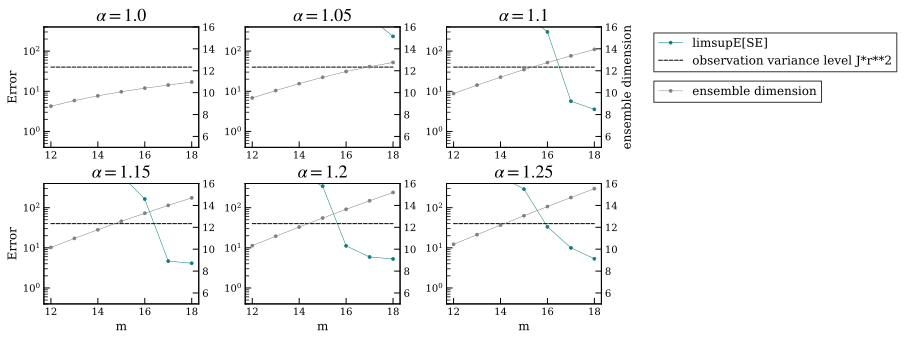

In [40]:
# Dependency on m and alpha
n_row, n_col = 2, 3
fig, ax = plt.subplots(n_row, n_col, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(n_row):
    for j in range(n_col):
        idx = n_col*i + j
        if n_col == 1 and n_row == 1:
            ax1 = ax
        elif n_col == 1 or n_row == 1:
            ax1 = ax[idx]
        else:
            ax1 = ax[i, j]
        ax2 = ax1.twinx()
        alpha = alpha_list[idx]
        ax1.set_title(f"$\\alpha={alpha}$")
        df_sup_se[alpha].plot.line(ax=ax1, marker="o", label="limsupE[SE]")
        # df_rmse[alpha].plot.line(ax=ax1, marker="o", label="RMSE")
        ax1.plot(m_reduced_list, J*r**2*np.ones_like(m_reduced_list), lw=1, c="black", ls="--", label="observation variance level J*r**2")
        
        df_ensdim[alpha].plot.line(ax=ax2, marker="o", label="ensemble dimension", color="grey")
        # df_traceP[alpha].plot.line(ax=ax1, marker="o", label="trace(P)", color="black")
            
        ax1.set_ylim([J*r**2/100, 10*J*r**2])
        ax1.set_yscale("log")
        if j==0:
            ax1.set_ylabel("Error")
        if i==n_row-1:
            ax1.set_xlabel("m")

        ax2.set_ylim([5, 16]) # TODO: scale Error J*r**2 equivalent to ensemble dimension 13
        if i==0 and j==n_col-1:
            ax2.set_ylabel("ensemble dimension")
            ax1.legend(bbox_to_anchor=(1.3, 1), loc='upper left')
            ax2.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')
        


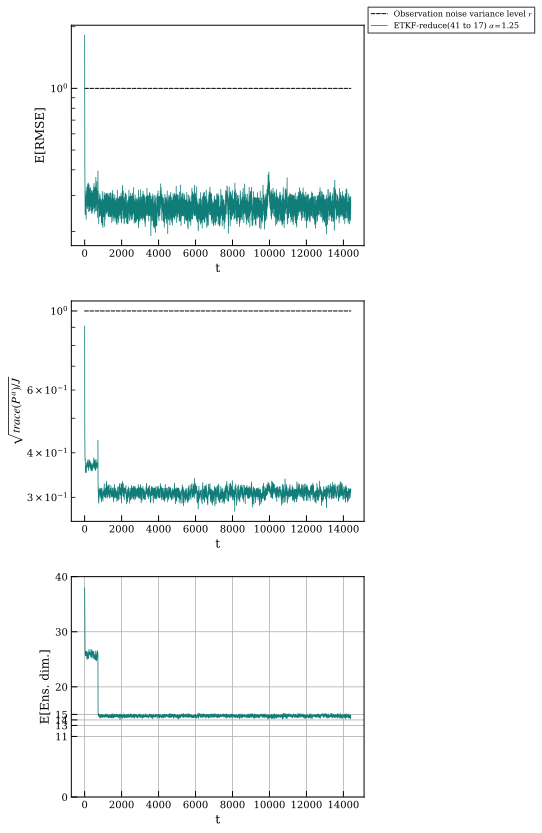

In [41]:
# Plot time series
# Require: Xa_dict

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
fig.subplots_adjust(hspace=0.1)
ax0, ax1, ax2 = ax
plot_type = "expectation" # "one sample", "all sample", "expectation"

# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax0, label='obs.', lw=0.5, color="k", ls="-")
plot_per = 1
t = np.arange(0, len(x_true))[::plot_per]

ax0.plot(t, r*np.ones_like(t), lw=1, c="black", ls="--", label="Observation noise variance level $ r $")
ax1.plot(t, r*np.ones_like(t), lw=1, c="black", ls="--")

i_alpha = 5
if plot_type == "one sample":
     k_seed = 0 # seed
     print("k_seed", k_seed)
for i in range(len(m_reduced_list)):
    if i != 5:
        continue
    for j in [i_alpha]:
        m_reduced, alpha, _ = param_dict[i, j, k]

        # ax0
        match plot_type:
            case "one sample":
                # plot rmse for seed k
                k = k_seed
                xa = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                plot_loss(x_true[::plot_per], xa[::plot_per], loss_rms, x_index=t, ax=ax0, label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
            case "all sample":
                # plot rmse samples over seeds
                for k in range(len(seeds)):
                    xa_k = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                    plot_loss(x_true[::plot_per], xa_k, loss_rms, x_index=t, ax=ax0, lw=0.3, alpha=0.5)
            case "expectation":
                # plot E[rmse]
                rmse_wt = []
                for k in range(len(seeds)):
                    xa_k = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                    rmse_k = np.linalg.norm(x_true-xa_k, axis=-1)/np.sqrt(J)
                    rmse_wt.append(rmse_k) # (N_seed, T)
                rmse_t = np.mean(np.array(rmse_wt), axis=0) # (T, )
                ax0.plot(t, rmse_t, label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        
        # ax1
        match plot_type:
            case "one sample":
                k = k_seed
                ax1.plot(t, np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)[::plot_per], label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
            case "all sample":
                for k in range(len(seeds)):
                    ax1.plot(t, np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)[::plot_per], lw=0.3, alpha=0.5)
            case "expectation":
                traceP_wt = []
                for k in range(len(seeds)):
                    traceP_k = np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)
                    traceP_wt.append(traceP_k)
                traceP_t = np.mean(np.array(traceP_wt), axis=0)
                ax1.plot(t, traceP_t, label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        # plot_loss((H@x_true[::plot_per].T).T, y[::plot_per], loss_rms, x_index=t, ax=ax1, label='obs.', lw=0.5, color="black", ls="-")
# 
        # ax1.legend(bbox_to_anchor=(1, 1.1), loc="upper left")

        # ax2
        match plot_type:
            case "one sample":
                k = k_seed
                ax2.plot(compute_edims(Xa_dict[i, j, k])[::plot_per], label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
            case "all sample":
                for k in range(len(seeds)):
                    ax2.plot(compute_edims(Xa_dict[i, j, k])[::plot_per], lw=0.3, alpha=0.5)
            case "expectation":
                edims_wt = []
                for k in range(len(seeds)):
                    edims_k = compute_edims(Xa_dict[i, j, k])
                    edims_wt.append(edims_k)
                edims_t = np.mean(np.array(edims_wt), axis=0)
                ax2.plot(edims_t, label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        ax2.set_xlabel('t')
        ax2.set_ylabel('Ens. dim.')
        # ax2.set_ylim([10, 20])
        ax2.set_yticks([0, 11, 13, 14, 15, 20, 30, 40])
        # ax2.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
        # arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
        # print(f"reduce ensemble at {N_spinup}")

# ax0
ax0.set_xlabel('t')
if plot_type == "expectation":
    ax0.set_ylabel('E[RMSE]')
else:
    ax0.set_ylabel('RMSE')
ax0.legend(bbox_to_anchor=(1, 1.1), loc="upper left", fontsize=8)
ax0.set_yscale("log")
fig.tight_layout()

# ax1
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\sqrt{trace(P^a)/J}$')
ax1.set_yscale('log')

# ax2
ax2.set_xlabel('t')
if plot_type == "expectation":
    ax2.set_ylabel('E[Ens. dim.]')
else:
    ax2.set_ylabel('Ens. dim.')
ax2.grid(True)


fig.tight_layout()



# Plot
# for i, m_reduced in enumerate(m_reduced_list):
#     plot_loss(x_true, etkf_list[i].x, loss_rms, ax=ax0, label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     plot_loss(x_true, etkf0_list[i].x, loss_rms, ax=ax0, label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax0, label='obs.', lw=0.5, color="k", ls="-")
# ax0.set_xlabel('t')
# ax0.set_ylabel('RMSE')
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# # ax0.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax0.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# ax0.set_ylim([0, 2])


# ax1 = ax[1]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax1.plot(np.sqrt(compute_traceP(etkf_list[i].X_a)/J), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax1.plot(np.sqrt(traceP(etkf0_list[i].X_a)/J), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax1, label='obs.', lw=0.5, color="k", ls="-")
# ax1.set_xlabel('t')
# ax1.set_ylabel(r'$\sqrt{trace(P^a)/J}$')
# ax1.set_yscale('log')
# ax1.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)

# X_a = etkf_list[-1].X_a
# print(etkf_list[-1].m)

# ax2 = ax[2]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax2.plot(compute_edims(etkf_list[i].X_a), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax2.plot(compute_edims(etkf0_list[i].X_a), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# ax2.set_xlabel('t')
# ax2.set_ylabel('Ens. dim.')
# # ax2.set_ylim([10, 20])
# ax2.set_yticks([0, 11, 13, 15, 20, 30, 40])
# ax2.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# print(f"reduce ensemble at {N_spinup}")
# # ax.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# # ax.set_ylim([0, 2])
# # ax.set_yscale("log")
# fig.tight_layout()
# plt.grid(True)
# fig.tight_layout()

In [42]:
# Plot
# for i, m_reduced in enumerate(m_reduced_list):
#     plot_loss(x_true, etkf_list[i].x, loss_rms, ax=ax0, label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     plot_loss(x_true, etkf0_list[i].x, loss_rms, ax=ax0, label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax0, label='obs.', lw=0.5, color="k", ls="-")
# ax0.set_xlabel('t')
# ax0.set_ylabel('RMSE')
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# # ax0.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax0.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# ax0.set_ylim([0, 2])
# ax0.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# ax0.set_yscale("log")
# fig.tight_layout()

# ax1 = ax[1]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax1.plot(np.sqrt(compute_traceP(etkf_list[i].X_a)/J), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax1.plot(np.sqrt(traceP(etkf0_list[i].X_a)/J), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax1, label='obs.', lw=0.5, color="k", ls="-")
# ax1.set_xlabel('t')
# ax1.set_ylabel(r'$\sqrt{trace(P^a)/J}$')
# ax1.set_yscale('log')
# ax1.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)

# X_a = etkf_list[-1].X_a
# print(etkf_list[-1].m)

# ax2 = ax[2]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax2.plot(compute_edims(etkf_list[i].X_a), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax2.plot(compute_edims(etkf0_list[i].X_a), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# ax2.set_xlabel('t')
# ax2.set_ylabel('Ens. dim.')
# # ax2.set_ylim([10, 20])
# ax2.set_yticks([0, 11, 13, 15, 20, 30, 40])
# ax2.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# print(f"reduce ensemble at {N_spinup}")
# # ax.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# # ax.set_ylim([0, 2])
# # ax.set_yscale("log")
# fig.tight_layout()
# plt.grid(True)
# fig.tight_layout()

## loop r

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import visualize as vis
from util import load_params

data_dir_r = "data/r{}"

logr_list = [0, 1, 2, 3, 4]

# load params
set_params = load_params(data_dir_r.format(0))
m_reduced_list = set_params.m_reduced_list

rmse_r = np.zeros((len(logr_list), len(m_reduced_list)))
sup_se_r = np.zeros((len(logr_list), len(m_reduced_list)))
for i, logr in enumerate(logr_list):
    dir = data_dir_r.format(logr)
    print(dir)

    # load params
    set_params = load_params(dir)

    # load data
    df_rmse = pd.read_csv(dir + "/rmse.csv", index_col=0, header=0)
    df_sup_se = pd.read_csv(dir + "/sup_se.csv", index_col=0, header=0)
    # print(df_sup_se)

    # optimal for each m
    rmse_opt = df_rmse.to_numpy().min(axis=1) # (len(m_reduced_list), )
    sup_se_opt = df_sup_se.to_numpy().min(axis=1) # (len(m_reduced_list), )
    rmse_r[i] = rmse_opt
    sup_se_r[i] = sup_se_opt

data/r0
data/r1
data/r2
data/r3
data/r4


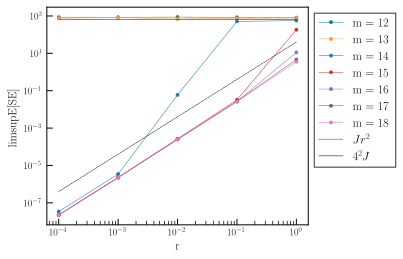

In [15]:
J = set_params.J
fig = plt.figure(figsize=(6, 4))
for i, m in enumerate(m_reduced_list):
    plt.plot(0.1**(np.array(logr_list)), sup_se_r[:, i], label=f"m = {m}", marker="o") 
plt.plot(0.1**(np.array(logr_list)), J*0.01**(np.array(logr_list)), color="black", ls="--", label="$Jr^2$")  
plt.plot(0.1**(np.array(logr_list)), J*16*np.ones_like(logr_list), color="black", ls="-", label="$4^2 J$")  
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r")
plt.ylabel("limsupE[SE]")
plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.savefig(f"data/sup_se_r.pdf")